# 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

In [2]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [3]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

In [4]:
def show_plots(series, r=3, c=2):
  fig, ax = plt.subplots(r, c, figsize=(14, 8))

  for i, key in enumerate(series):
    ax_i = ax[math.floor(i/c)][i%c]
    series[key].plot(ax=ax_i)

    ax_i.grid()
    ax_i.set_title(key)
    plt.tight_layout()

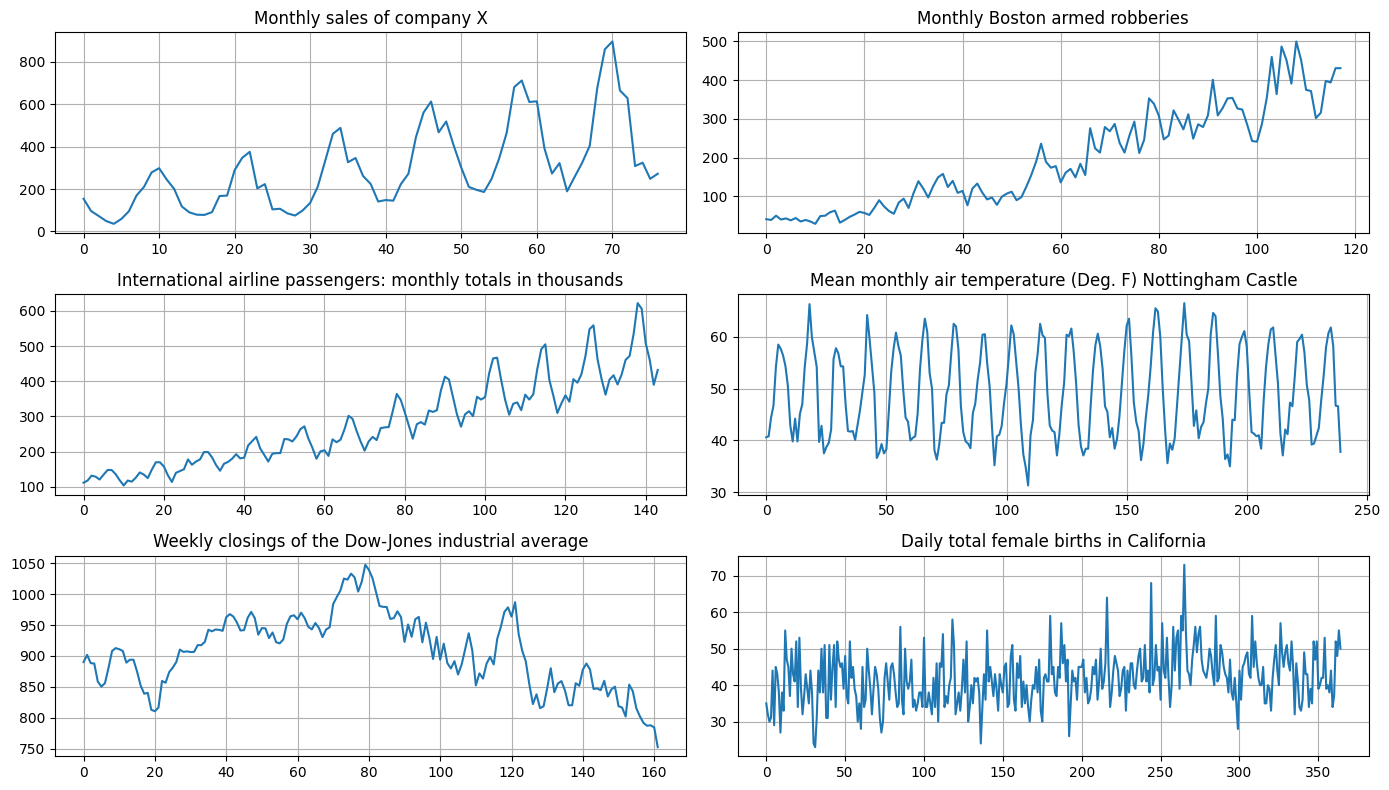

In [5]:
show_plots(all_series)

# 2. Приведение ряда к стационарному

In [6]:
from scipy.stats import boxcox

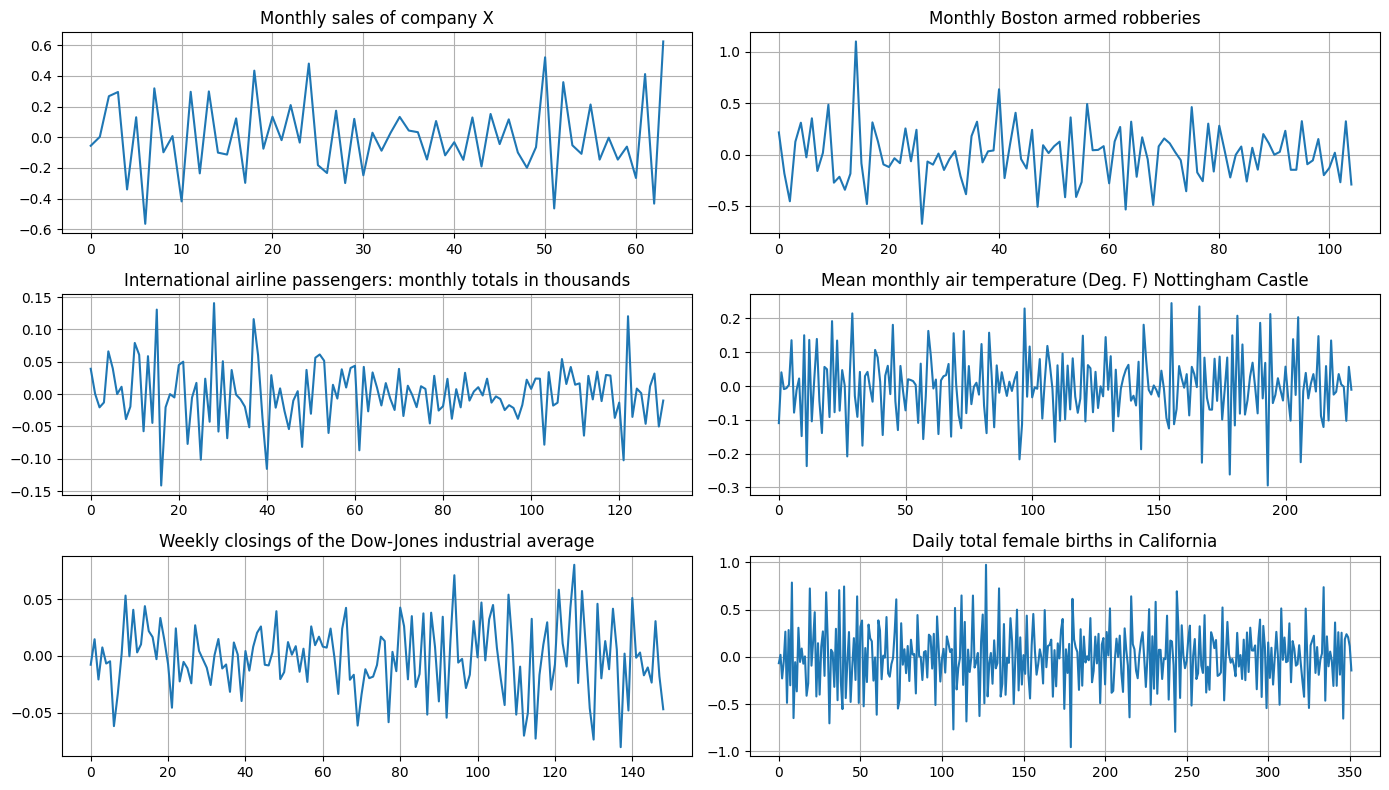

In [7]:
fix_series = {}

for key in all_series.keys():
  fix_series[key] = boxcox(all_series[key], 0)
  fix_series[key] = fix_series[key][1:] - fix_series[key][:-1]
  fix_series[key] = fix_series[key][12:] - fix_series[key][:-12]
  fix_series[key] = pd.Series(fix_series[key])

show_plots(fix_series)

# 3. Скользящее среднее, взвешенное скользящее среднее, экспоненциальное сглаживание, двойное экспоненциальное сглаживание

## Набор функций

In [79]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [81]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [113]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [125]:
def double_exponential_moving_average(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [161]:
def ma(series, n_ma, n_wma, weights_wma, alpha_ema, alpha_dema, beta_dema):
  fig, ax = plt.subplots(6, 1, figsize=(12, 20))

  for i, key in enumerate(series):
    series[key].plot(ax=ax[i], label='original')

    ma = moving_average(series[key], n_ma)
    ma.plot(ax=ax[i], label='moving average')

    wma = weighted_moving_average(series[key], n_wma, weights_wma)
    wma.plot(ax=ax[i], label='weighted moving average')

    ema = exponential_moving_average(series[key], alpha_ema)
    ema.plot(ax=ax[i], label='exponential moving average')

    dema = double_exponential_moving_average(series[key], alpha_dema, beta_dema)
    dema.plot(ax=ax[i], label='double exponential moving average')

    ax[i].grid()
    ax[i].set_title(key)
    ax[i].legend()
    plt.tight_layout()

## Не стационарный ряд

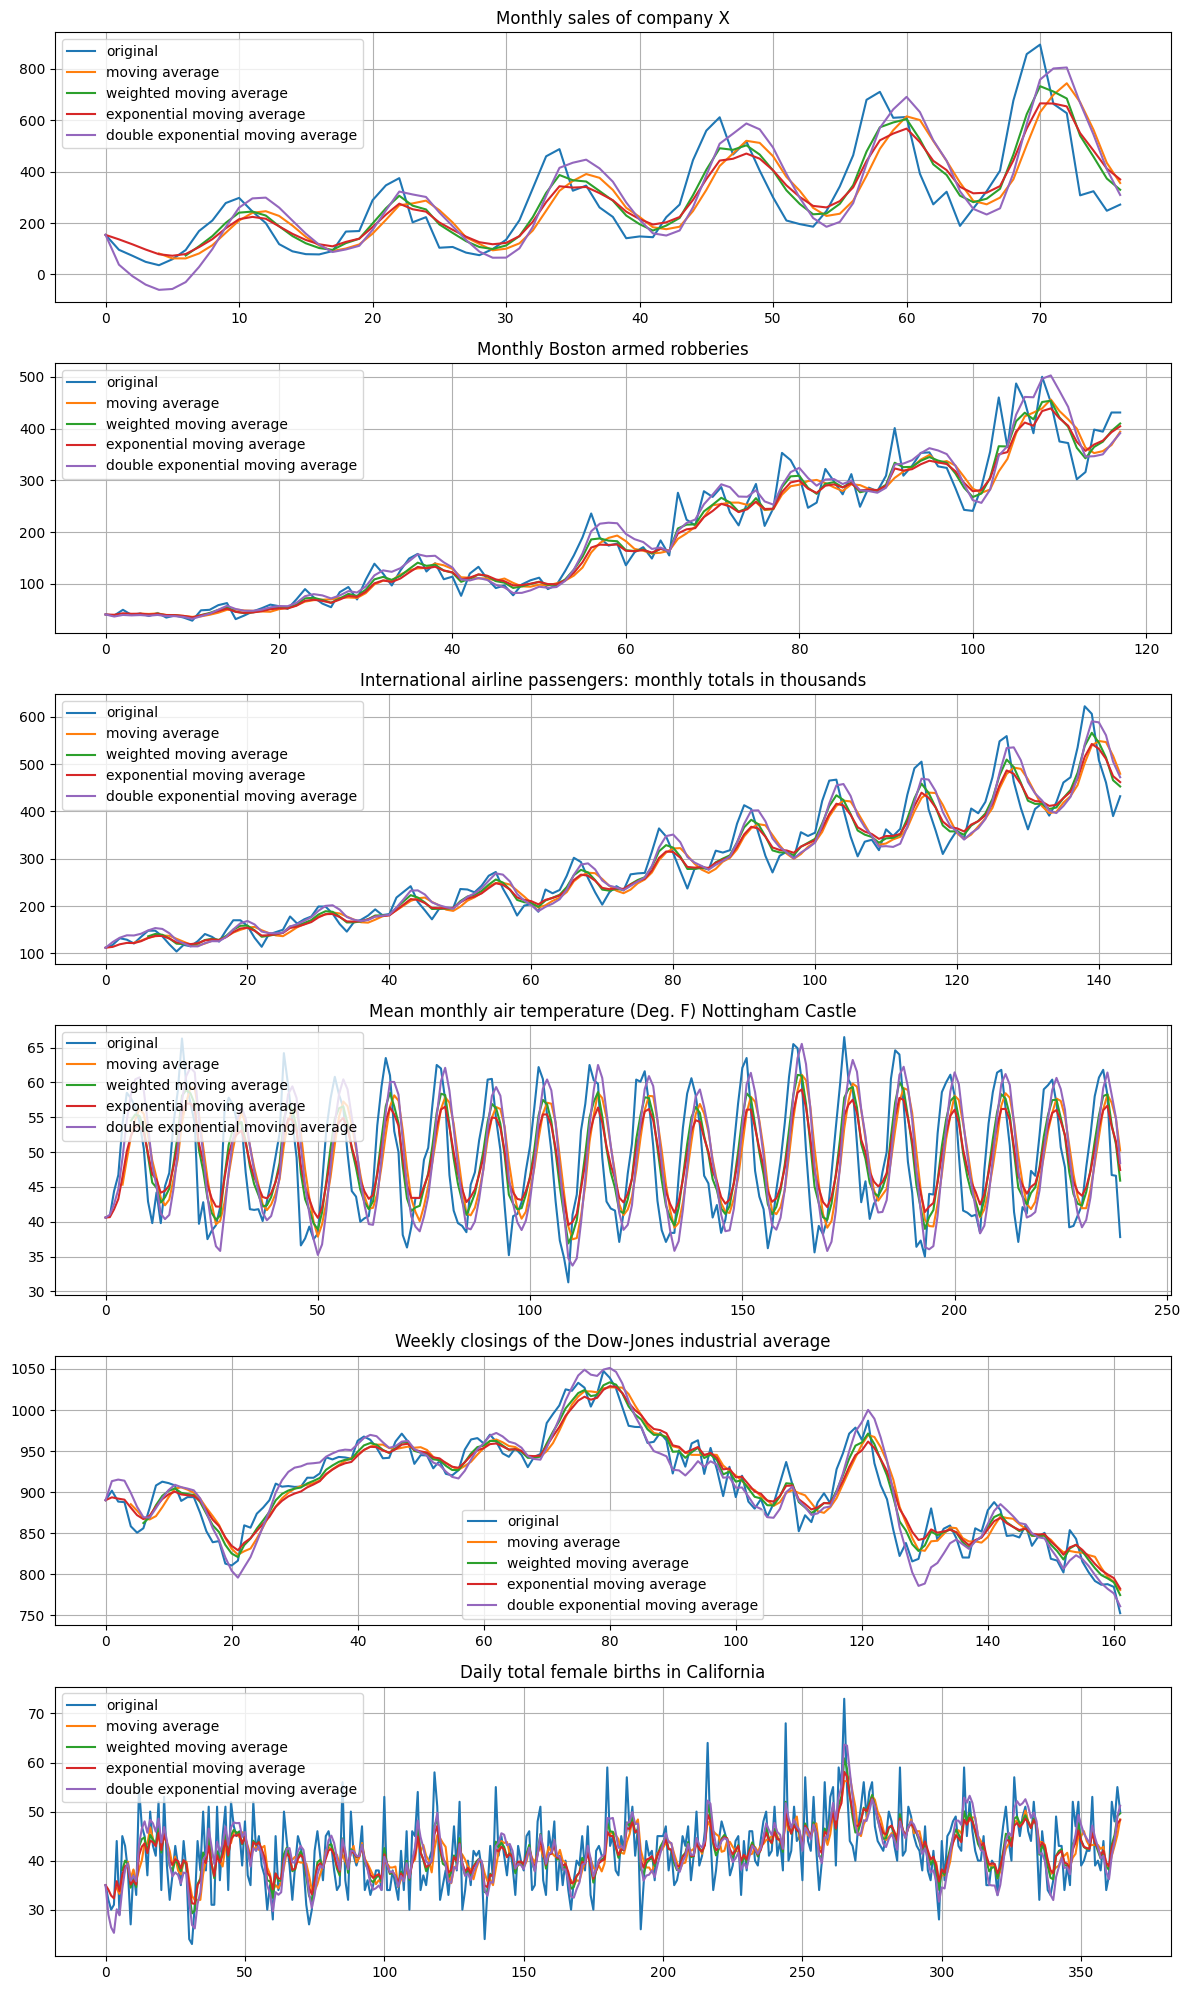

In [172]:
ma(all_series,
   n_ma=5,
   n_wma=7, weights_wma=[1,1,2,3,5,8,13],
   alpha_ema=0.3,
   alpha_dema=0.3, beta_dema=0.3)

## Стационарный ряд

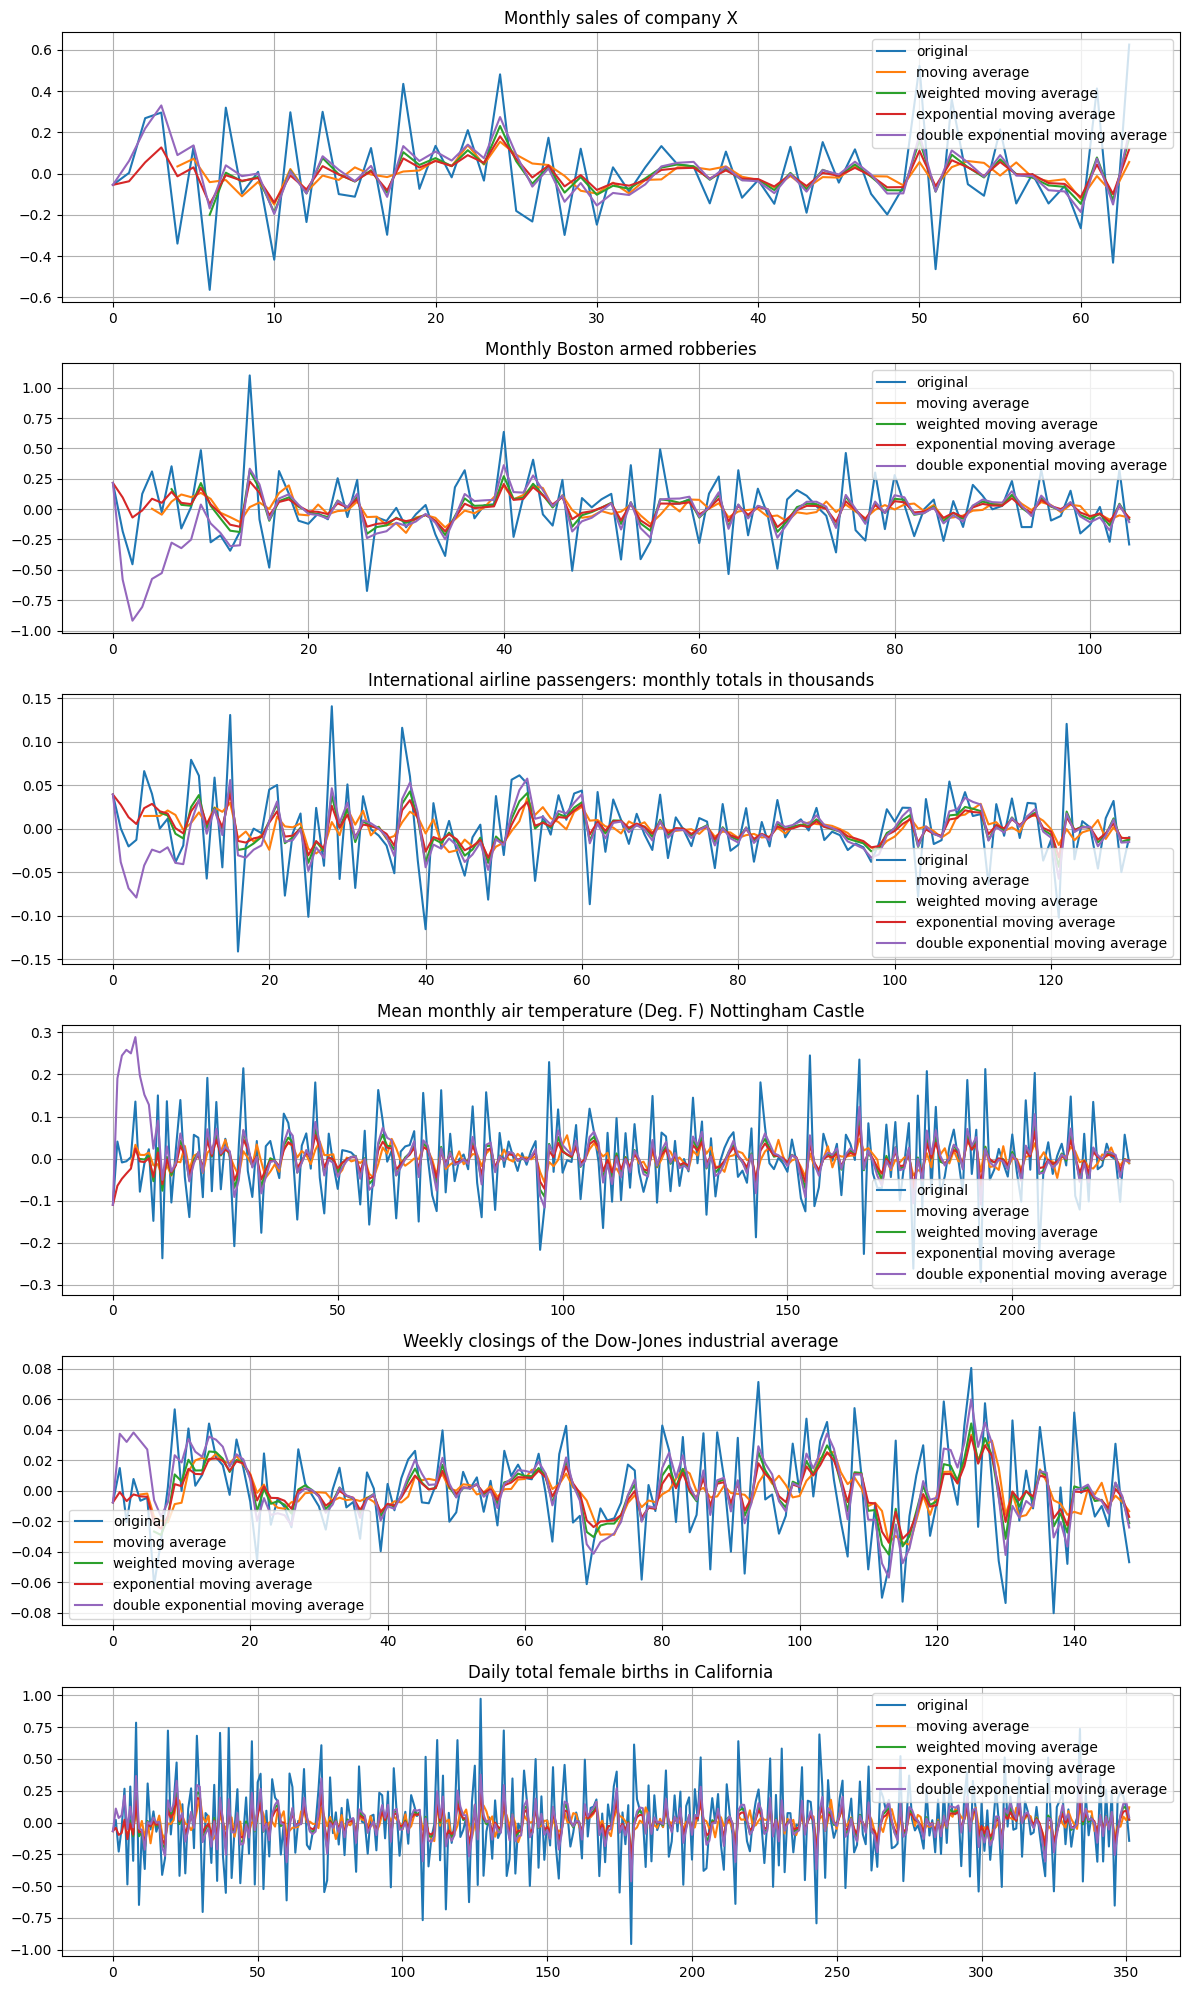

In [163]:
ma(fix_series,
   n_ma=5,
   n_wma=7, weights_wma=[1,1,2,3,5,8,13],
   alpha_ema=0.3,
   alpha_dema=0.4, beta_dema=0.2)

# 4. Хольт-Винтерс + кросс-валидация

## Набор функций

In [8]:
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [9]:
def initial_seasonal_components(series, seasons_len):
  seasonals = {}
  season_averages = []
  n_seasons = int(len(series) / seasons_len)

  for i in range(n_seasons):
    season_average = sum(series[i*seasons_len:(i+1)*seasons_len]) / float(seasons_len)
    season_averages.append(season_average)

  for i in range(seasons_len):
    sum_of_vals_over_avg = 0.0
    for j in range(n_seasons):
      sum_of_vals_over_avg += series[j*seasons_len+i] - season_averages[j]
    seasonals[i] = sum_of_vals_over_avg/n_seasons

  return seasonals

In [10]:
def triple_exponential_smoothing(series, seasons_len, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, seasons_len)

    smooth = series[0]
    trend = sum([float(series[seasons_len] - series[0]) / seasons_len]) / seasons_len
    result.append(smooth)

    for i in range(len(series)+n_preds)[1:]:
      if i >= len(series):
        m = i - len(series) + 1
        result.append((smooth + m*trend) + seasonals[i%seasons_len])
      else:
        val = series[i]
        last_smooth, smooth = smooth, alpha*(val-seasonals[i%seasons_len]) + (1-alpha)*(smooth+trend)
        trend = beta * (smooth-last_smooth) + (1-beta)*trend
        seasonals[i%seasons_len] = gamma*(val-smooth) + (1-gamma)*seasonals[i%seasons_len]
        result.append(smooth + trend + seasonals[i%seasons_len])
    return result

In [52]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(mean_monthly_temp):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [176]:
def cross_val(series, seasons_len=12, r=3, c=2):
  fig, ax = plt.subplots(r, c, figsize=(14, 8))

  for i, key in enumerate(series):
    value = series[key]
    len_train = int(len(value)*0.7)
    train, test = value[:len_train], value[len_train:]
    n_preds = len(value) - len_train

    opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
    alpha_opt, beta_opt, gamma_opt = opt.x

    tema = pd.Series(triple_exponential_smoothing(train, seasons_len, alpha_opt, beta_opt, gamma_opt, n_preds))
    ax_i = ax[math.floor(i/c)][i%c]
    value.plot(ax=ax_i, color='blue', label='original')
    tema.plot(ax=ax_i, color='red', linewidth='4', label='predict')

    err_text = f'R2={r2_score(tema, value)}\nR2_train={r2_score(tema[:len_train], value[:len_train])}, R2_test={r2_score(tema[len_train:], value[len_train:])}'

    ax_i.grid()
    ax_i.set_title(f'{key}\n{err_text}')
    ax_i.legend()
    plt.tight_layout()

  print(f'alpha={alpha_opt}, beta={beta_opt}, gamma={gamma_opt}')

## Нестационарный ряд

alpha=0.05554688420936781, beta=0.19055537964048538, gamma=0.9114797110207403


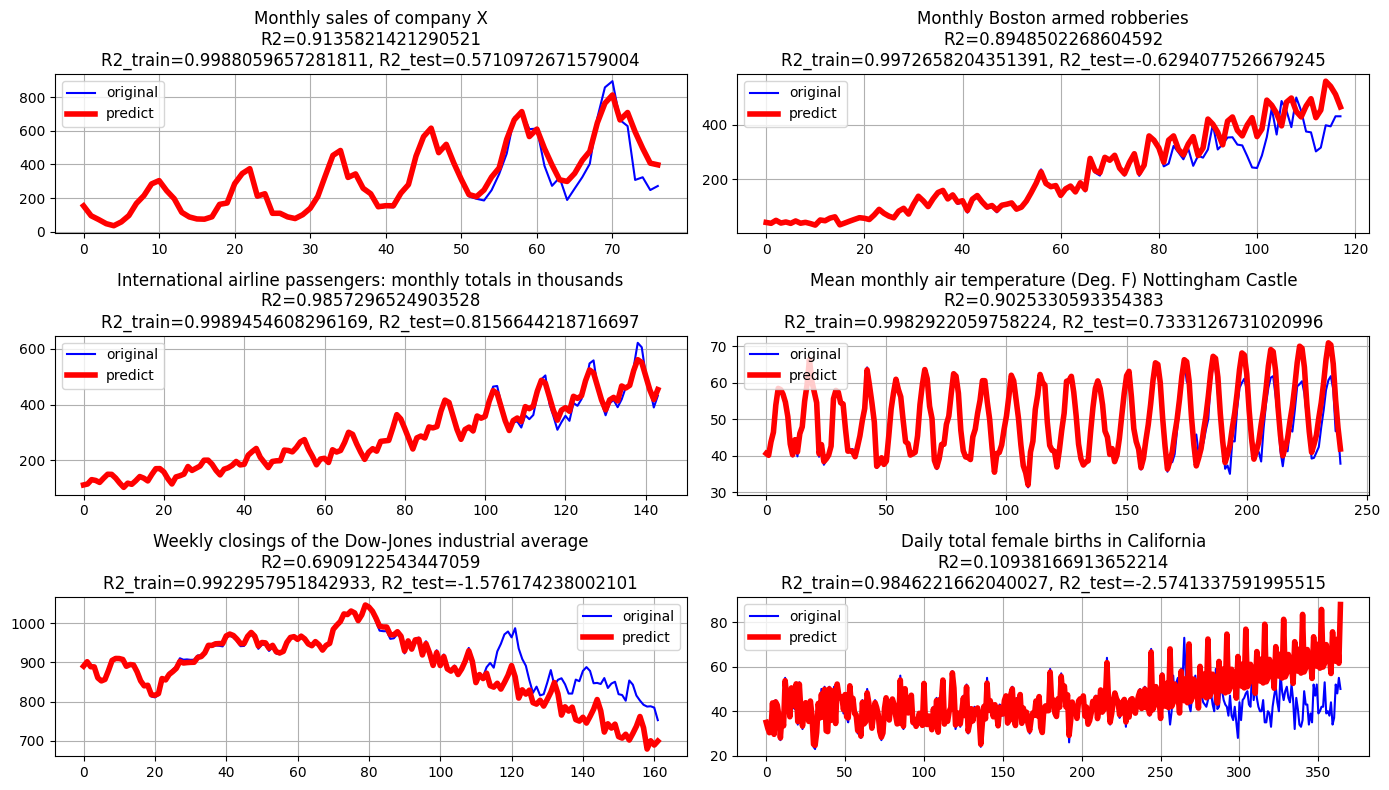

In [179]:
cross_val(all_series)

## Стационарный ряд

alpha=0.05554688420936781, beta=0.19055537964048538, gamma=0.9114797110207403


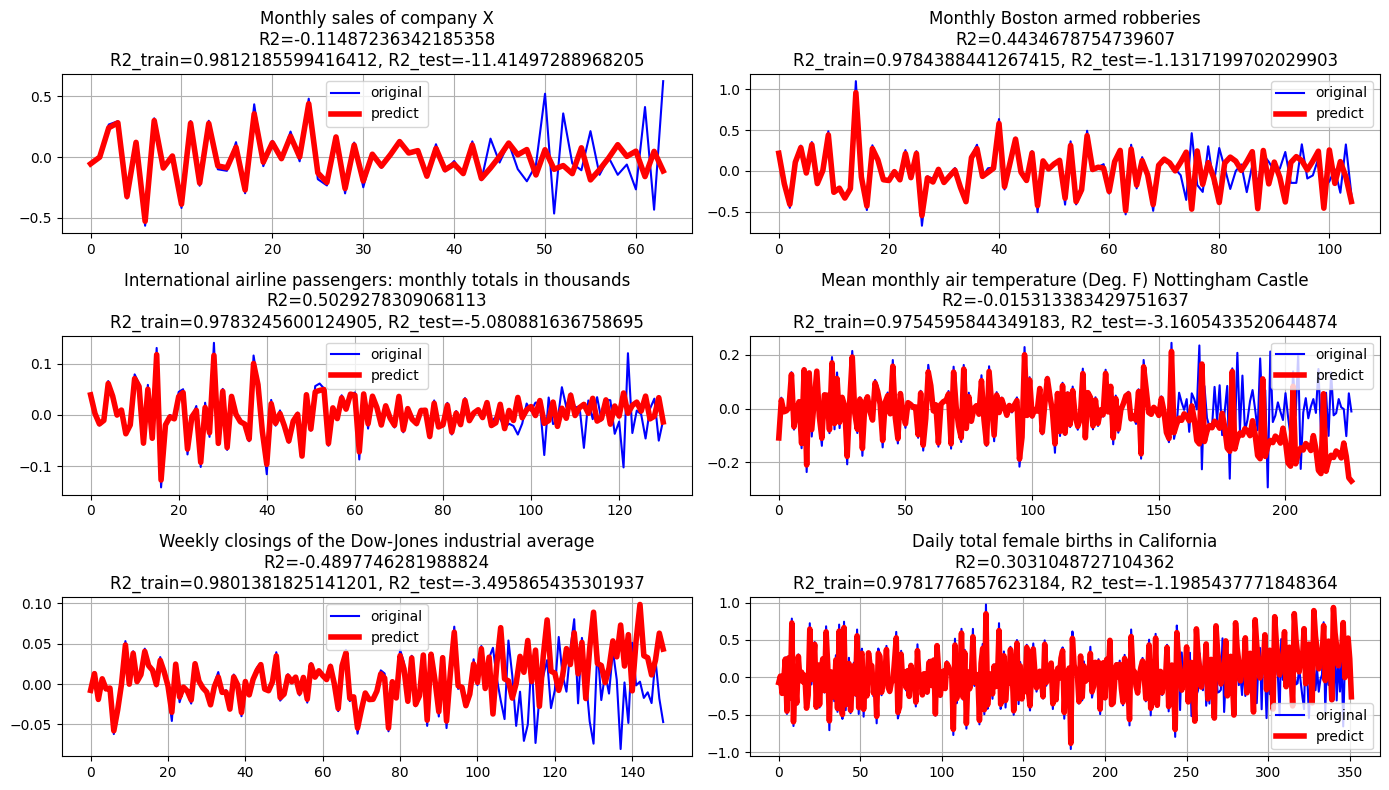

In [178]:
cross_val(fix_series)

# 5. Выводы

Двойное экспоненциальное сглаживание в целом хорошо описывает ряд (особенно в случае нестационарного)

Хольт-Винтерс плохо работает только со стационарным рядом, тк у него отсутсвует сезонность. Из-за этого метрика R2 для тестовых данных совсем плохая.

По графику можно заметить, что (особенно для нестационарного ряда) предсказанные значения сильно зависят от линии тренда.
Из-за этого значение метрики R2 для тестовых данных хуже чем для тренироваочных.